# ゲイン調節と四則演算

{cite:p}`Goldwyn2018-ug`を実装．神経演算 (neuronal arithmetic; {cite:p}`Angus_Silver2010-fd`)のモデル．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot, ProgressMeter, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
@kwdef struct HHIAParameter{FT}
    Cm::FT  = 1 # 膜容量(uF/cm^2)
    gNa::FT = 37; gK::FT = 45; gA::FT = 20; gL::FT = 1 # Na, K, Kₐ, leakの最大コンダクタンス(mS/cm^2)
    ENa::FT = 55; EK::FT = -80; EL::FT = -70 #Na, K, leakの平衡電位(mV)
    gExc::FT = 0.5; gInh::FT = 1
    VExc::FT = 0;   VInh::FT = -85
    βExc::FT = 0.2; βInh::FT = 0.18
    tr::FT = 0.5;   td::FT = 8 # ms
    γ1::FT = 1/td;  γ2::FT = 1/tr - 1/td
    v0::FT = -20 # mV
end

@kwdef mutable struct HHIA{FT}
    param::HHIAParameter = HHIAParameter{FT}()
    N::Int
    v::Vector{FT} = fill(-70, N); r::Vector{FT} = zeros(N)
    n::Vector{FT} = fill(1/(1 + exp(-(-70 + 32)/8)), N)
    a::Vector{FT} = fill(1/(1 + exp(-(-70 + 50)/20)), N)
    b::Vector{FT} = fill(1/(1 + exp((-70 + 70)/6)), N)
    sExc::Vector{FT} = zeros(N); sInh::Vector{FT} = zeros(N)
end

In [3]:
function update!(variable::HHIA, param::HHIAParameter, spikesExc::Vector, spikesInh::Vector, dt)
    @unpack N, v, n, a, b, r, sExc, sInh = variable
    @unpack Cm, gNa, gK, gL, gA, ENa, EK, EL, gExc, gInh, VExc, VInh, βExc, βInh, γ1, γ2, v0 = param
    @inbounds for i = 1:N
        m, h = 1 / (1 + exp(-(v[i]+30)/15)), 1 - n[i]
        
        n[i] += dt * 0.75(1/(1 + exp(-0.125(v[i] + 32))) - n[i]) / (1 + 100 / (1 + exp((v[i] + 80)/26)))
        a[i] += dt * 0.5(1/(1 + exp(-0.05(v[i] + 50))) - a[i])
        b[i] += dt * (1.0/(1 + exp((v[i] + 70)/6)) - b[i]) / 150
        
        sExc[i] += -sExc[i] * βExc*dt + spikesExc[i]
        sInh[i] += -sInh[i] * βInh*dt + spikesInh[i]
        IExc = gExc * sExc[i] * (v[i] - VExc) 
        IInh = gInh * sInh[i] * (v[i] - VInh)

        IL = gL * (v[i] - EL)
        IK = gK * n[i]^4 * (v[i] - EK)
        IA = gA * a[i]^3 * b[i] * (v[i] - EK)
        INa = gNa * m^3 * h * (v[i] - ENa)
        
        v[i] += dt/Cm * -(IL + IK + IA + INa + IExc + IInh)
        r[i] += dt * (γ2 * (1.0 - r[i])/(1.0 + exp(-v[i] + v0)) - r[i] * γ1)
    end
end

update! (generic function with 1 method)

In [4]:
function GammaSpike(T, dt, n_neurons, fr, k)
    nt = Int(T/dt) # number of timesteps
    θ = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*θ)

    isi = rand(Gamma(k, θ), Int(round(nt*1.5/fr)), n_neurons)
    spike_time = cumsum(isi, dims=1) # ISIを累積
    spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
    spike_time = round.(Int, spike_time) # float to int
    spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

    for i=1:n_neurons    
        spikes[spike_time[:, i], i] .= 1
    end

    spikes[1] = 0 # (spike_time=1)の発火を削除
    return spikes
end

GammaSpike (generic function with 1 method)

In [5]:
function FIcurve(neurons, spikesExc, spikesInh, T=5000, dt=0.01)
    nt = Int(T/dt) # number of timesteps
    varr = zeros(Float32, nt,  neurons.N)
    
    @showprogress for t = 1:nt
        update!(neurons, neurons.param, spikesExc[t, :], spikesInh[t, :], dt)
        varr[t, :] = neurons.v
    end
    
    spike = (varr[1:nt-1, :] .< 0) .& (varr[2:nt, :] .> 0)
    output_spikes = sum(spike, dims=1) / T*1e3
    input_spikes = sum(spikesExc, dims=1) / T*1e3
    return input_spikes, output_spikes
end

FIcurve (generic function with 3 methods)

In [6]:
T, dt = 50000, 5e-2 # ms
nt = Int(T/dt)
N = 100
maxfrExc = 80; frInh = [0, 50]; 

In [7]:
function HHIAFIcurve_multi(gA, T, dt, N, maxfrExc, frInh)
    nInh = size(frInh)[1]
    input_spikes_arr, output_spikes_arr = zeros(nInh, N), zeros(nInh, N)
    nt = Int(T/dt) # number of timesteps
    frExc = rand(N) * maxfrExc
    spikesExc = zeros(Int, nt, N)
    for j = 1:N
        spikesExc[:, j] = rand(nt) .< frExc[j]*dt*1e-3
    end
    for i=1:nInh
        spikesInh = (frInh[i] == 0) ? zeros(Int, nt, N) : GammaSpike(T, dt, N, frInh[i], 12)    
        neurons = HHIA{Float32}(N=N, param=HHIAParameter{Float32}(gA=gA)) # modelの定義
        input_spikes_arr[i, :], output_spikes_arr[i, :] = FIcurve(neurons, spikesExc, spikesInh, T, dt)
    end
    return input_spikes_arr, output_spikes_arr
end

HHIAFIcurve_multi (generic function with 1 method)

In [8]:
input_spikes1, output_spikes1 = HHIAFIcurve_multi(20, T, dt, N, maxfrExc, frInh);
input_spikes2, output_spikes2 = HHIAFIcurve_multi(40, T, dt, N, maxfrExc, frInh);

Progress:   0%|█                                        |  ETA: 0:00:29

Progress:  10%|█████                                    |  ETA: 0:00:12

Progress:  12%|█████                                    |  ETA: 0:00:12

Progress:  13%|██████                                   |  ETA: 0:00:11

Progress:  14%|██████                                   |  ETA: 0:00:11

Progress:  15%|███████                                  |  ETA: 0:00:11

Progress:  17%|███████                                  |  ETA: 0:00:10

Progress:  18%|████████                                 |  ETA: 0:00:10

Progress:  19%|████████                                 |  ETA: 0:00:10

Progress:  20%|█████████                                |  ETA: 0:00:09

Progress:  21%|█████████                                |  ETA: 0:00:09

Progress:  23%|██████████                               |  ETA: 0:00:09

Progress:  24%|██████████                               |  ETA: 0:00:09

Progress:  25%|███████████                              |  ETA: 0:00:09

Progress:  26%|███████████                              |  ETA: 0:00:09

Progress:  27%|████████████                             |  ETA: 0:00:08

Progress:  28%|████████████                             |  ETA: 0:00:08

Progress:  30%|█████████████                            |  ETA: 0:00:08

Progress:  31%|█████████████                            |  ETA: 0:00:08

Progress:  32%|██████████████                           |  ETA: 0:00:08

Progress:  33%|██████████████                           |  ETA: 0:00:07

Progress:  34%|███████████████                          |  ETA: 0:00:07

Progress:  36%|███████████████                          |  ETA: 0:00:07

Progress:  37%|████████████████                         |  ETA: 0:00:07

Progress:  38%|████████████████                         |  ETA: 0:00:07

Progress:  39%|█████████████████                        |  ETA: 0:00:07

Progress:  40%|█████████████████                        |  ETA: 0:00:06

Progress:  41%|██████████████████                       |  ETA: 0:00:06

Progress:  43%|██████████████████                       |  ETA: 0:00:06

Progress:  44%|██████████████████                       |  ETA: 0:00:06

Progress:  45%|███████████████████                      |  ETA: 0:00:06

Progress:  46%|███████████████████                      |  ETA: 0:00:06

Progress:  48%|████████████████████                     |  ETA: 0:00:06

Progress:  49%|████████████████████                     |  ETA: 0:00:05

Progress:  50%|█████████████████████                    |  ETA: 0:00:05

Progress:  51%|█████████████████████                    |  ETA: 0:00:05

Progress:  52%|██████████████████████                   |  ETA: 0:00:05

Progress:  53%|██████████████████████                   |  ETA: 0:00:05

Progress:  55%|███████████████████████                  |  ETA: 0:00:05

Progress:  56%|███████████████████████                  |  ETA: 0:00:05

Progress:  57%|████████████████████████                 |  ETA: 0:00:04

Progress:  58%|████████████████████████                 |  ETA: 0:00:04

Progress:  59%|█████████████████████████                |  ETA: 0:00:04

Progress:  61%|█████████████████████████                |  ETA: 0:00:04

Progress:  62%|██████████████████████████               |  ETA: 0:00:04

Progress:  63%|██████████████████████████               |  ETA: 0:00:04

Progress:  64%|███████████████████████████              |  ETA: 0:00:04

Progress:  65%|███████████████████████████              |  ETA: 0:00:04

Progress:  66%|████████████████████████████             |  ETA: 0:00:03

Progress:  68%|████████████████████████████             |  ETA: 0:00:03

Progress:  69%|█████████████████████████████            |  ETA: 0:00:03

Progress:  70%|█████████████████████████████            |  ETA: 0:00:03

Progress:  71%|██████████████████████████████           |  ETA: 0:00:03[

39m

Progress:  72%|██████████████████████████████           |  ETA: 0:00:03

Progress:  74%|███████████████████████████████          |  ETA: 0:00:03

Progress:  75%|███████████████████████████████          |  ETA: 0:00:03

Progress:  76%|████████████████████████████████         |  ETA: 0:00:02

Progress:  77%|████████████████████████████████         |  ETA: 0:00:02

Progress:  78%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  79%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  81%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  82%|██████████████████████████████████       |  ETA: 0:00:02[39

Progress:  83%|███████████████████████████████████      |  ETA: 0:00:02

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:02

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:02

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:01[3

9m

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  89%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:01[39

m

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  98%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Progress:   1%|█                                        |  ETA: 0:00:19

Progress:   2%|█                                        |  ETA: 0:00:13

Progress:   3%|██                                       |  ETA: 0:00:12

Progress:   4%|██                                       |  ETA: 0:00:12

Progress:   5%|██                                       |  ETA: 0:00:11

Progress:   6%|███                                      |  ETA: 0:00:11

Progress:   7%|███                                      |  ETA: 0:00:10

Progress:   8%|████                                     |  ETA: 0:00:10

Progress:  10%|████                                     |  ETA: 0:00:09

Progress:  11%|█████                                    |  ETA: 0:00:09

Progress:  12%|█████                                    |  ETA: 0:00:09

Progress:  13%|██████                                   |  ETA: 0:00:09

Progress:  14%|██████                                   |  ETA: 0:00:08

Progress:  16%|███████                                  |  ETA: 0:00:08

Progress:  17%|███████                                  |  ETA: 0:00:08

Progress:  18%|████████                                 |  ETA: 0:00:08

Progress:  19%|████████                                 |  ETA: 0:00:08

Progress:  21%|█████████                                |  ETA: 0:00:08

Progress:  22%|█████████                                |  ETA: 0:00:07

Progress:  23%|██████████                               |  ETA: 0:00:07

Progress:  24%|██████████                               |  ETA: 0:00:07

Progress:  26%|███████████                              |  ETA: 0:00:07

Progress:  27%|███████████                              |  ETA: 0:00:07

Progress:  28%|████████████                             |  ETA: 0:00:07

Progress:  29%|████████████                             |  ETA: 0:00:07

Progress:  30%|█████████████                            |  ETA: 0:00:07

Progress:  32%|█████████████                            |  ETA: 0:00:06

Progress:  33%|██████████████                           |  ETA: 0:00:06

Progress:  34%|██████████████                           |  ETA: 0:00:06

Progress:  35%|███████████████                          |  ETA: 0:00:06

Progress:  37%|███████████████                          |  ETA: 0:00:06

Progress:  38%|████████████████                         |  ETA: 0:00:06

Progress:  39%|█████████████████                        |  ETA: 0:00:06

Progress:  40%|█████████████████                        |  ETA: 0:00:06

Progress:  42%|██████████████████                       |  ETA: 0:00:06

Progress:  43%|██████████████████                       |  ETA: 0:00:06

Progress:  44%|███████████████████                      |  ETA: 0:00:05

Progress:  45%|███████████████████                      |  ETA: 0:00:05

Progress:  47%|████████████████████                     |  ETA: 0:00:05

Progress:  48%|████████████████████                     |  ETA: 0:00:05

Progress:  49%|█████████████████████                    |  ETA: 0:00:05

Progress:  50%|█████████████████████                    |  ETA: 0:00:05

Progress:  52%|██████████████████████                   |  ETA: 0:00:05

Progress:  53%|██████████████████████                   |  ETA: 0:00:05

Progress:  54%|███████████████████████                  |  ETA: 0:00:04

Progress:  55%|███████████████████████                  |  ETA: 0:00:04

Progress:  56%|████████████████████████                 |  ETA: 0:00:04

Progress:  58%|████████████████████████                 |  ETA: 0:00:04

Progress:  59%|█████████████████████████                |  ETA: 0:00:04

Progress:  60%|█████████████████████████                |  ETA: 0:00:04

Progress:  61%|██████████████████████████               |  ETA: 0:00:04

Progress:  63%|██████████████████████████               |  ETA: 0:00:04

Progress:  64%|███████████████████████████              |  ETA: 0:00:03

Progress:  65%|███████████████████████████              |  ETA: 0:00:03

Progress:  66%|████████████████████████████             |  ETA: 0:00:03

Progress:  68%|████████████████████████████             |  ETA: 0:00:03

Progress:  69%|█████████████████████████████            |  ETA: 0:00:03

Progress:  70%|█████████████████████████████            |  ETA: 0:00:03

Progress:  71%|██████████████████████████████           |  ETA: 0:00:03

Progress:  73%|██████████████████████████████           |  ETA: 0:00:03

Progress:  74%|███████████████████████████████          |  ETA: 0:00:02

Progress:  75%|███████████████████████████████          |  ETA: 0:00:02

Progress:  76%|████████████████████████████████         |  ETA: 0:00:02

Progress:  78%|████████████████████████████████         |  ETA: 0:00:02

Progress:  79%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  81%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:02

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:01

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  89%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Progress:   1%|█                                        |  ETA: 0:00:11

Progress:   2%|█                                        |  ETA: 0:00:10

Progress:   3%|██                                       |  ETA: 0:00:10

Progress:   4%|██                                       |  ETA: 0:00:10

Progress:   5%|███                                      |  ETA: 0:00:10

Progress:   6%|███                                      |  ETA: 0:00:10

Progress:   7%|███                                      |  ETA: 0:00:10

Progress:   8%|████                                     |  ETA: 0:00:10

Progress:   9%|████                                     |  ETA: 0:00:10

Progress:  10%|█████                                    |  ETA: 0:00:10

Progress:  11%|█████                                    |  ETA: 0:00:10

Progress:  12%|█████                                    |  ETA: 0:00:10

Progress:  13%|██████                                   |  ETA: 0:00:10

Progress:  14%|██████                                   |  ETA: 0:00:10

Progress:  15%|███████                                  |  ETA: 0:00:09

Progress:  16%|███████                                  |  ETA: 0:00:09

Progress:  17%|████████                                 |  ETA: 0:00:09

Progress:  19%|████████                                 |  ETA: 0:00:09

Progress:  20%|█████████                                |  ETA: 0:00:08

Progress:  21%|█████████                                |  ETA: 0:00:08

Progress:  22%|██████████                               |  ETA: 0:00:08

Progress:  23%|██████████                               |  ETA: 0:00:08

Progress:  25%|███████████                              |  ETA: 0:00:08

Progress:  26%|███████████                              |  ETA: 0:00:08

Progress:  27%|████████████                             |  ETA: 0:00:07

Progress:  28%|████████████                             |  ETA: 0:00:07

Progress:  29%|█████████████                            |  ETA: 0:00:07

Progress:  31%|█████████████                            |  ETA: 0:00:07

Progress:  32%|██████████████                           |  ETA: 0:00:07

Progress:  33%|██████████████                           |  ETA: 0:00:07

Progress:  34%|███████████████                          |  ETA: 0:00:07

Progress:  36%|███████████████                          |  ETA: 0:00:06

Progress:  37%|████████████████                         |  ETA: 0:00:06

Progress:  38%|████████████████                         |  ETA: 0:00:06

Progress:  39%|█████████████████                        |  ETA: 0:00:06

Progress:  40%|█████████████████                        |  ETA: 0:00:06

Progress:  42%|██████████████████                       |  ETA: 0:00:06

Progress:  43%|██████████████████                       |  ETA: 0:00:06

Progress:  44%|███████████████████                      |  ETA: 0:00:06

Progress:  45%|███████████████████                      |  ETA: 0:00:05

Progress:  46%|████████████████████                     |  ETA: 0:00:05

Progress:  48%|████████████████████                     |  ETA: 0:00:05

Progress:  49%|████████████████████                     |  ETA: 0:00:05

Progress:  50%|█████████████████████                    |  ETA: 0:00:05

Progress:  51%|█████████████████████                    |  ETA: 0:00:05

Progress:  52%|██████████████████████                   |  ETA: 0:00:05

Progress:  54%|██████████████████████                   |  ETA: 0:00:05

Progress:  55%|███████████████████████                  |  ETA: 0:00:04

Progress:  56%|███████████████████████                  |  ETA: 0:00:04

Progress:  57%|████████████████████████                 |  ETA: 0:00:04

Progress:  58%|████████████████████████                 |  ETA: 0:00:04

Progress:  60%|█████████████████████████                |  ETA: 0:00:04

Progress:  61%|█████████████████████████                |  ETA: 0:00:04

Progress:  62%|██████████████████████████               |  ETA: 0:00:04

Progress:  63%|██████████████████████████               |  ETA: 0:00:04

Progress:  64%|███████████████████████████              |  ETA: 0:00:03

Progress:  66%|███████████████████████████              |  ETA: 0:00:03

Progress:  67%|████████████████████████████             |  ETA: 0:00:03

Progress:  68%|████████████████████████████             |  ETA: 0:00:03

Progress:  69%|█████████████████████████████            |  ETA: 0:00:03

Progress:  71%|█████████████████████████████            |  ETA: 0:00:03

Progress:  72%|██████████████████████████████           |  ETA: 0:00:03

Progress:  73%|██████████████████████████████           |  ETA: 0:00:03

Progress:  74%|███████████████████████████████          |  ETA: 0:00:02

Progress:  75%|███████████████████████████████          |  ETA: 0:00:02

Progress:  77%|████████████████████████████████         |  ETA: 0:00:02

Progress:  78%|████████████████████████████████         |  ETA: 0:00:02

Progress:  79%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  81%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:02

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:01

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  89%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  93%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  98%|█████████████████████████████████████████|  ETA: 0:00:00

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Progress:   1%|█                                        |  ETA: 0:00:11

Progress:   2%|█                                        |  ETA: 0:00:10

Progress:   3%|██                                       |  ETA: 0:00:10

Progress:   4%|██                                       |  ETA: 0:00:10

Progress:   5%|███                                      |  ETA: 0:00:10

Progress:   6%|███                                      |  ETA: 0:00:10

Progress:   8%|████                                     |  ETA: 0:00:09

Progress:   9%|████                                     |  ETA: 0:00:09

Progress:  10%|█████                                    |  ETA: 0:00:09

Progress:  11%|█████                                    |  ETA: 0:00:09

Progress:  13%|██████                                   |  ETA: 0:00:08

Progress:  14%|██████                                   |  ETA: 0:00:08

Progress:  15%|███████                                  |  ETA: 0:00:08

Progress:  16%|███████                                  |  ETA: 0:00:08

Progress:  18%|████████                                 |  ETA: 0:00:08

Progress:  19%|████████                                 |  ETA: 0:00:07

Progress:  20%|█████████                                |  ETA: 0:00:07

Progress:  21%|█████████                                |  ETA: 0:00:07

Progress:  23%|██████████                               |  ETA: 0:00:07

Progress:  24%|██████████                               |  ETA: 0:00:07

Progress:  25%|███████████                              |  ETA: 0:00:07

Progress:  26%|███████████                              |  ETA: 0:00:07

Progress:  28%|████████████                             |  ETA: 0:00:07

Progress:  29%|████████████                             |  ETA: 0:00:06

Progress:  30%|█████████████                            |  ETA: 0:00:06

Progress:  31%|█████████████                            |  ETA: 0:00:06

Progress:  33%|██████████████                           |  ETA: 0:00:06

Progress:  34%|██████████████                           |  ETA: 0:00:06

Progress:  35%|███████████████                          |  ETA: 0:00:06

Progress:  36%|███████████████                          |  ETA: 0:00:06

Progress:  38%|████████████████                         |  ETA: 0:00:06

Progress:  39%|█████████████████                        |  ETA: 0:00:05

Progress:  40%|█████████████████                        |  ETA: 0:00:05

Progress:  42%|██████████████████                       |  ETA: 0:00:05

Progress:  43%|██████████████████                       |  ETA: 0:00:05

Progress:  44%|███████████████████                      |  ETA: 0:00:05

Progress:  45%|███████████████████                      |  ETA: 0:00:05

Progress:  47%|████████████████████                     |  ETA: 0:00:05

Progress:  48%|████████████████████                     |  ETA: 0:00:05

Progress:  49%|█████████████████████                    |  ETA: 0:00:05

Progress:  50%|█████████████████████                    |  ETA: 0:00:04

Progress:  51%|██████████████████████                   |  ETA: 0:00:04

Progress:  53%|██████████████████████                   |  ETA: 0:00:04

Progress:  54%|███████████████████████                  |  ETA: 0:00:04

Progress:  55%|███████████████████████                  |  ETA: 0:00:04

Progress:  57%|████████████████████████                 |  ETA: 0:00:04

Progress:  58%|████████████████████████                 |  ETA: 0:00:04

Progress:  59%|█████████████████████████                |  ETA: 0:00:04

Progress:  60%|█████████████████████████                |  ETA: 0:00:04

Progress:  62%|██████████████████████████               |  ETA: 0:00:03

Progress:  63%|██████████████████████████               |  ETA: 0:00:03

Progress:  64%|███████████████████████████              |  ETA: 0:00:03

Progress:  65%|███████████████████████████              |  ETA: 0:00:03

Progress:  67%|████████████████████████████             |  ETA: 0:00:03

Progress:  68%|████████████████████████████             |  ETA: 0:00:03

Progress:  69%|█████████████████████████████            |  ETA: 0:00:03

Progress:  70%|█████████████████████████████            |  ETA: 0:00:03

Progress:  71%|██████████████████████████████           |  ETA: 0:00:03

Progress:  73%|██████████████████████████████           |  ETA: 0:00:02

Progress:  74%|███████████████████████████████          |  ETA: 0:00:02

Progress:  75%|███████████████████████████████          |  ETA: 0:00:02

Progress:  76%|████████████████████████████████         |  ETA: 0:00:02

Progress:  78%|████████████████████████████████         |  ETA: 0:00:02

Progress:  79%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:02

Progress:  81%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:02

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:01

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:01

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:01

Progress:  89%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:01

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:01

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


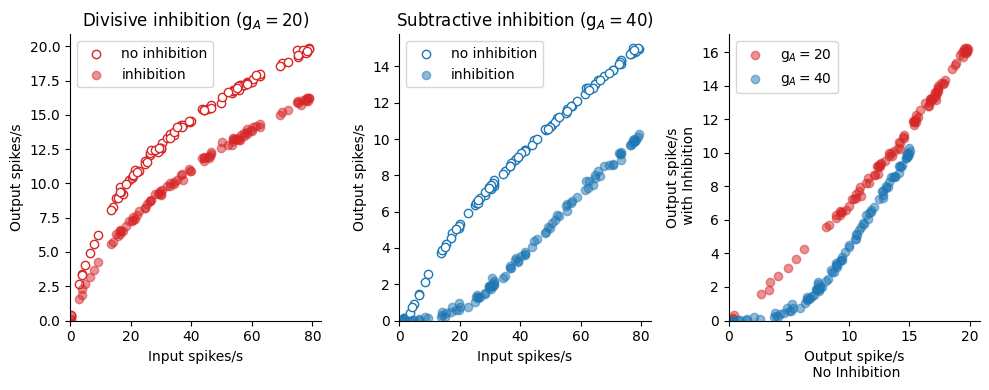

In [9]:
figure(figsize=(10, 4))
subplot(1,3,1); title(L"Divisive inhibition (g$_A=20$)")
scatter(input_spikes1[1, :], output_spikes1[1, :], facecolor="white", edgecolors="tab:red", label="no inhibition")
scatter(input_spikes1[2, :], output_spikes1[2, :], alpha=0.5, color="tab:red", label="inhibition")
xlim(0, ); ylim(0, ); xlabel("Input spikes/s"); ylabel("Output spikes/s"); legend()
subplot(1,3,2); title(L"Subtractive inhibition (g$_A=40$)")
scatter(input_spikes2[1, :], output_spikes2[1, :], facecolor="white", edgecolors="tab:blue", label="no inhibition")
scatter(input_spikes2[2, :], output_spikes2[2, :], alpha=0.5, color="tab:blue", label="inhibition")
xlim(0, ); ylim(0, ); xlabel("Input spikes/s"); ylabel("Output spikes/s"); legend()
subplot(1,3,3);
scatter(output_spikes1[1, :], output_spikes1[2, :], alpha=0.5, color="tab:red", label=L"g$_A=20$")
scatter(output_spikes2[1, :], output_spikes2[2, :], alpha=0.5, color="tab:blue", label=L"g$_A=40$")
xlim(0, ); ylim(0, ); xlabel("Output spike/s\n No Inhibition"); ylabel("Output spike/s\n with Inhibition"); legend()
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```